In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sqlalchemy as db

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim import Adam

from IPython.display import clear_output

In [2]:
print("CUDA available", torch.cuda.is_available())
print("CUDA dev count", torch.cuda.device_count())
print("CUDA dev curr", torch.cuda.current_device())
print("CUDA dev", torch.cuda.device(0))
print("CUDA dev name", torch.cuda.get_device_name(0))

CUDA available True
CUDA dev count 1
CUDA dev curr 0
CUDA dev <torch.cuda.device object at 0x000001874EA31510>
CUDA dev name NVIDIA GeForce GTX 1650


Connection to DLSU Cloud DB (PAL)
- `connection.json` is abstracted for data privacy

Reading the Historical Data

In [3]:
conn = pd.read_json('connection.json', typ='series')
host = conn['host']
user = conn['user']
password = conn['password']
port = conn['port']
engine = db.create_engine('mysql+pymysql://' + user + ':' + password + '@' + host + ':' + port + '/' + 'Historical')

def query_historical(table_name):
    query = f"SELECT * FROM {table_name}"
    hist = pd.read_sql(query, engine)
    hist.index = hist['index']
    hist.drop('index', axis=1, inplace=True)
    return hist

In [4]:
palb777 = query_historical('PALB777_hour')
pala321c = query_historical('PALA321C_hour')
gapa321c = query_historical('GAPA321C_hour')

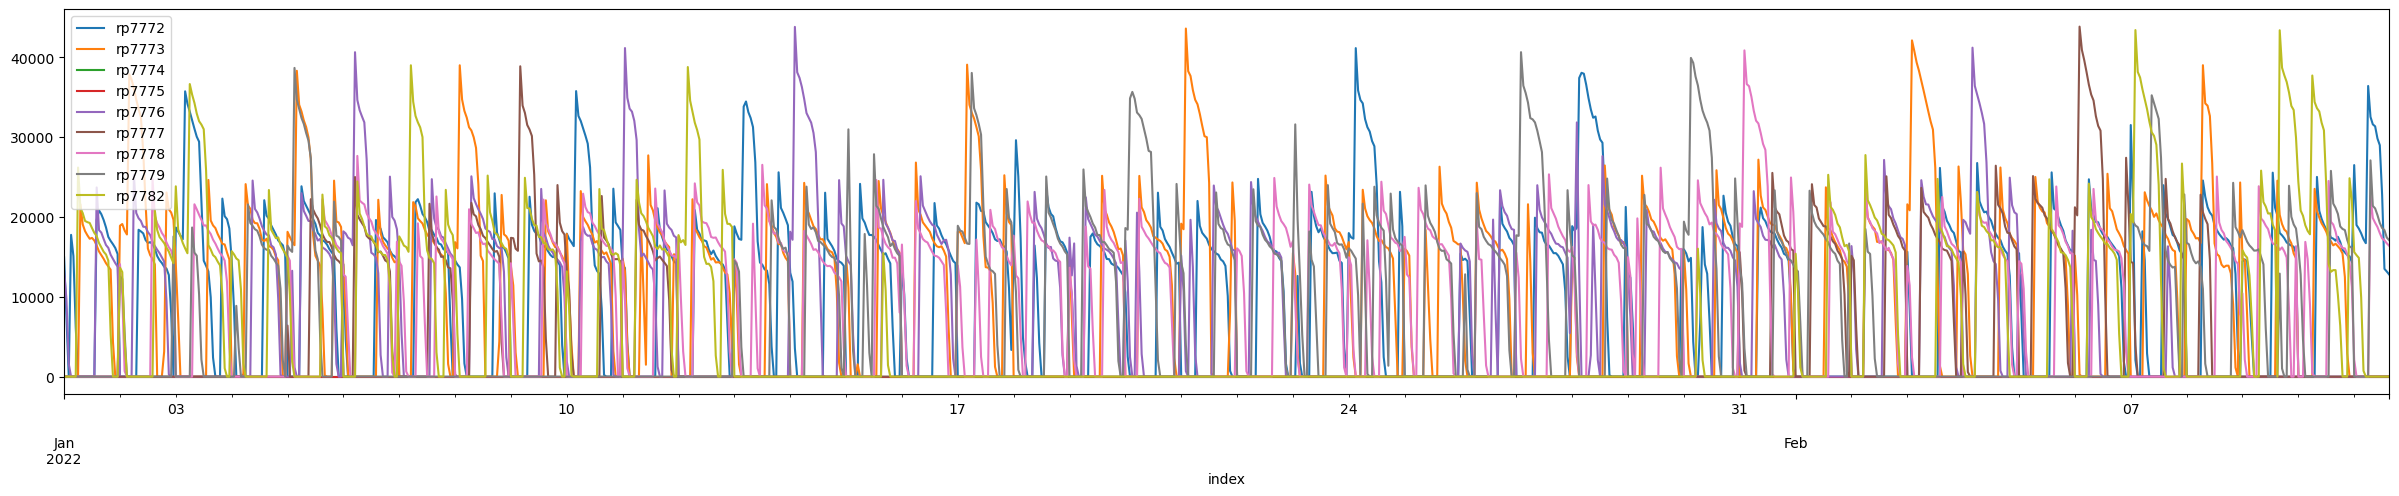

In [5]:
palb777[:1000].plot(figsize=(30,5))
plt.show()

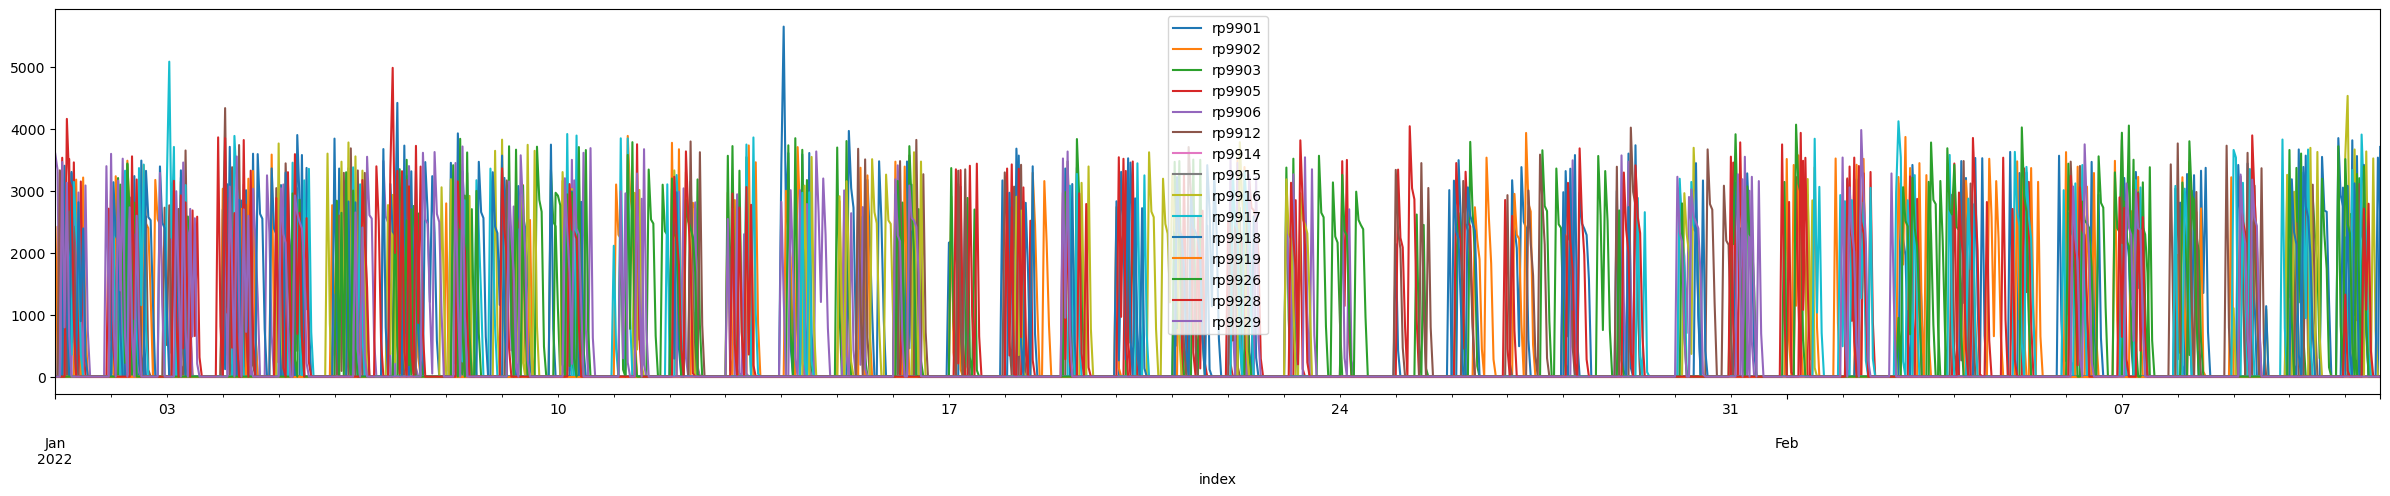

In [6]:
pala321c[:1000].plot(figsize=(30,5))
plt.show()

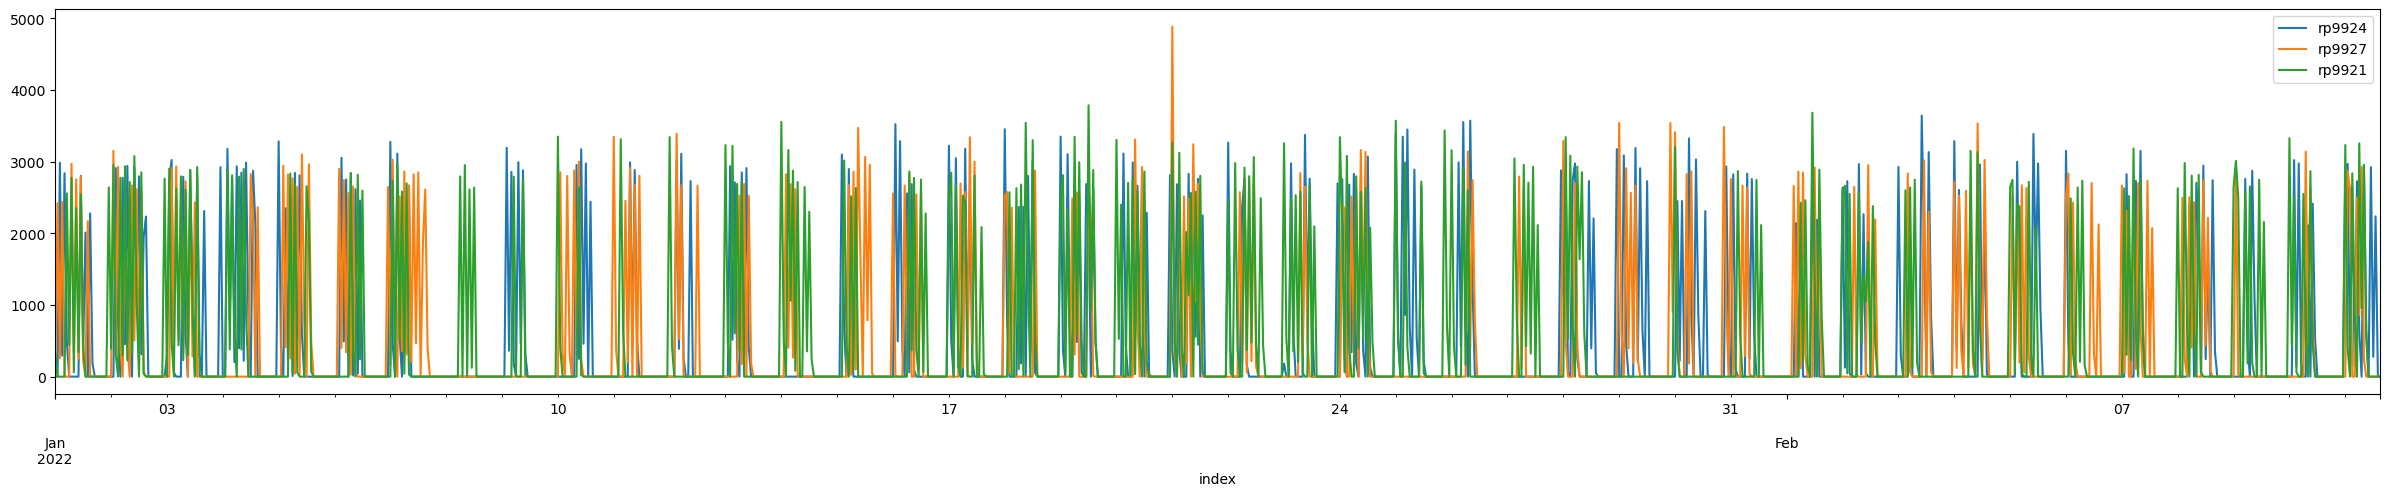

In [7]:
gapa321c[:1000].plot(figsize=(30,5))
plt.show()

# EDA & Preprocessing

In [8]:
hist = pd.concat([palb777, gapa321c, pala321c], axis=1).fillna(0)

In [9]:
hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15167 entries, 2022-01-01 00:00:00 to 2023-09-24 22:00:00
Freq: H
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rp7772  15167 non-null  float64
 1   rp7773  15167 non-null  float64
 2   rp7774  15167 non-null  float64
 3   rp7775  15167 non-null  float64
 4   rp7776  15167 non-null  float64
 5   rp7777  15167 non-null  float64
 6   rp7778  15167 non-null  float64
 7   rp7779  15167 non-null  float64
 8   rp7782  15167 non-null  float64
 9   rp9924  15167 non-null  float64
 10  rp9927  15167 non-null  float64
 11  rp9921  15167 non-null  float64
 12  rp9901  15167 non-null  float64
 13  rp9902  15167 non-null  float64
 14  rp9903  15167 non-null  float64
 15  rp9905  15167 non-null  float64
 16  rp9906  15167 non-null  float64
 17  rp9912  15167 non-null  float64
 18  rp9914  15167 non-null  float64
 19  rp9915  15167 non-null  float64
 20  rp9916  15167 non-null  float

In [10]:
hist.describe()

,rp7772,rp7773,rp7774,rp7775,rp7776,rp7777,rp7778,rp7779,rp7782,rp9924,...,rp9912,rp9914,rp9915,rp9916,rp9917,rp9918,rp9919,rp9926,rp9928,rp9929
count,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,...,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000
mean,9084.342686,5085.247437,569.734959,3459.848711,3675.624093,4694.237881,5817.094252,5701.875285,6154.639672,466.490818,...,532.096632,453.963355,43.371633,476.442226,463.210240,450.023013,454.560976,481.109949,543.268010,476.816759
std,10095.576421,8944.019925,3508.308840,7782.193918,7986.441379,8816.908037,9064.834853,9137.011880,9668.689192,1020.983165,...,1100.586007,1052.639235,350.415930,1056.362606,1059.403851,1029.567964,1032.998198,1075.794969,1127.088560,1063.408055
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1762.191111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17731.146667,11142.077778,0.000000,0.000000,0.000000,761.437778,15609.200000,15453.533333,15790.866667,29.725139,...,2.955833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,47314.755556,45496.164444,44033.791111,59026.795556,51505.040000,52611.413333,43916.324444,52218.631111,82163.244444,7039.134444,...,6439.778333,8981.754722,6483.148889,7795.167778,7473.126111,7279.197778,7368.576667,7886.771667,7913.008889,8124.937222


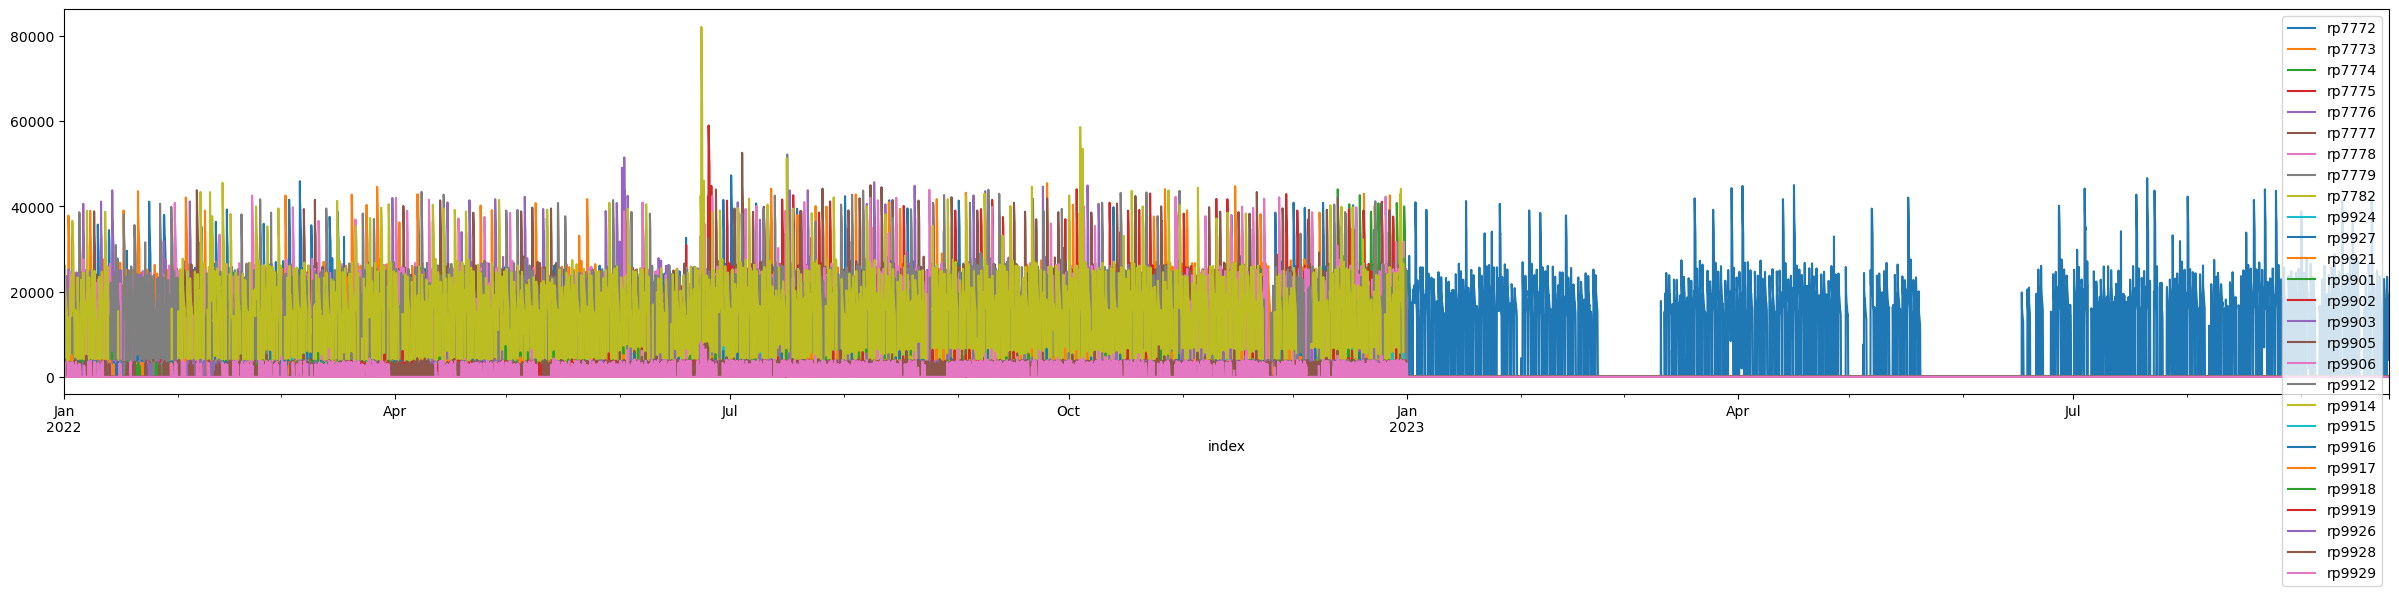

In [11]:
hist.plot(figsize=(30,5))
plt.show()

Data Aggregation

In [12]:
agg = input("Monthly [M], Weekly [W], Daily [D], Hourly [H]: ")
agg = agg.upper()
if agg == 'W':
    agg += '-' + hist.index[1].day_name()[:3]
placeholder = hist
hist = hist.resample(agg).sum()
inc23 = input('Include year 2023 (yes - Y):')
if inc23 != 'Y':
    hist = hist[:365*24]

Monthly [M], Weekly [W], Daily [D], Hourly [H]: h
Include year 2023 (yes - Y):n


In [13]:
hist

,rp7772,rp7773,rp7774,rp7775,rp7776,rp7777,rp7778,rp7779,rp7782,rp9924,...,rp9912,rp9914,rp9915,rp9916,rp9917,rp9918,rp9919,rp9926,rp9928,rp9929
index,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,14937.640000,0.000000,0.000000,0.0,13186.493333,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-01 01:00:00,7586.662222,0.000000,0.000000,0.0,9737.026667,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-01 02:00:00,61.453333,0.000000,0.000000,0.0,1589.364444,0.000000,0.000000,0.000000,0.0,2985.678333,...,3329.510556,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-01 03:00:00,17754.422222,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,294.136389,...,1898.623889,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3465.137500
2022-01-01 04:00:00,15098.808889,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,2838.475556,...,11.903611,0.000000,0.0,0.0,2985.395000,3403.426389,0.000000,0.000000,0.000000,794.927222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,13214.257778,15721.924444,0.000000,0.0,15698.688889,16769.031111,19536.968889,19023.942222,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,2005.938611,2487.428611,0.000000,0.000000,2829.933889,0.000000
2022-12-31 20:00:00,0.000000,12959.493333,0.000000,0.0,12539.937778,16840.960000,18157.831111,17892.382222,0.0,3201.277500,...,0.000000,0.000000,0.0,0.0,386.703611,2398.393333,3161.138056,2635.634722,2647.816111,0.000000
2022-12-31 21:00:00,0.000000,2969.982222,25031.764444,0.0,3216.173333,16006.115556,17824.693333,17499.213333,0.0,459.316667,...,0.000000,2672.311667,0.0,0.0,0.000000,925.576944,1038.102778,400.358611,857.872222,0.000000


Separate the data

In [14]:
hist_list = []
for each in list(hist.columns):
    hist_list.append(hist[[each]])

Process the data

In [15]:
# ss = StandardScaler()
time_step = 408 # time step for preprocessing
pred_step = 1   # number of predictions

def time_step_prep(data, time_step,pred_step):
    X = []
    y = []
    for i in range(time_step, data.shape[0]-pred_step):
        X.append(list(data.iloc[i-time_step:i, 0].values.reshape(-1)))
        y.append(list(data.iloc[i:i+pred_step, 0].values.reshape(-1)))
    return X, y

In [16]:
X, y = np.array([[]]), np.array([[]])
for each in hist_list:
    X_n, y_n = time_step_prep(each, time_step, pred_step)
    if X.shape[1] == 0 and y.shape[1] == 0:
        X = np.array(X_n)
        y = np.array(y_n)
    else:
        X = np.concatenate([X, np.array(X_n)])
        y = np.concatenate([y, np.array(y_n)])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(180381, 408)
(180381, 1)
(45096, 408)
(45096, 1)


Standardization

In [19]:
class Scaler:
    mean = 0.0
    std = 0.0
    def fit(self, X):
        self.mean = X.mean()
        self.std = X.std()
    def transform(self, X):
        return (X - self.mean)/self.std
    def inverse(self, X):
        return (X * self.std) + self.mean

In [103]:
ss = Scaler()
ss.fit(X_train)

X_train = ss.transform(X_train)
X_test = ss.transform(X_test)
y_train = ss.transform(y_train)
y_test = ss.transform(y_test)

Convert the data to torch

In [104]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

# Prediction Models

Construct Prediction Models

In [105]:
# LSTM based prediction model
class LSTM_based(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        self.lstm = nn.LSTM(self.in_dim, self.hid_dim, self.layer, batch_first=True)
        
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):        
        # forward propagate
        out, (h_,c_) = self.lstm(x)
        out = self.fc(out)
        return out
    
# RNN based prediction model
class RNN_based(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        
        # define the dimensions
        self.in_dim = in_dim
        self.hid_dim = in_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        # define the rnn layer
        self.rnn = nn.RNN(self.in_dim, self.hid_dim, self.layer, nonlinearity='relu', batch_first=True)
        
        # define fully connected layer for output
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):
        # forward propagate
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

# Simple Autoregressive Model
auto_reg = nn.Linear(time_step,pred_step)

In [106]:
input_features = X_train.shape[-1]
hidden_size = 32
num_layers = 2
out_size = 1

# model = LSTM_based(input_features, hidden_size, out_size, num_layers)
model = auto_reg

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# loss_fun = nn.L1Loss()
loss_fun = nn.MSELoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=800, gamma=0.1)

In [107]:
train_loss = []
test_loss = []

def train_model(model,
               criterion,
               optimizer,
               x_train,
               x_test,
               y_train,
               y_test,
               scheduler=None,
               epochs=500):
    
    global train_loss
    global test_loss
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        # put default model grads to zero
        optimizer.zero_grad()
        
        # predict the output
        pred = model(x_train)
        
        # calculate the loss 
        error = criterion(pred, y_train)
        
        # backpropagate the error
        error.backward()
        
        # update the model parameters
        optimizer.step()
        
        # save the losses 
        train_loss[epoch] = error.item()
        
        # test loss 
        test_pred = model(x_test)
        test_error = criterion(y_test,test_pred)
        test_loss[epoch] = test_error.item()
        
        # scheduler
        if scheduler is not None:
            scheduler.step()
        
        if (epoch+1) % 5 ==0:
            print('Epoch :{}    Train Loss :{}    Test Loss :{}'.format((epoch+1)/epochs, error.item(), test_error.item()))
            
#     return train_loss, test_loss

In [108]:
train_model(
    model, 
    loss_fun,
    optimizer, 
    X_train, 
    X_test,
    y_train, 
    y_test,
    scheduler,
    2000
)

Epoch :0.0025    Train Loss :354.9740295410156    Test Loss :247.39476013183594
Epoch :0.005    Train Loss :175.1652069091797    Test Loss :152.103759765625
Epoch :0.0075    Train Loss :69.37553405761719    Test Loss :96.37203216552734
Epoch :0.01    Train Loss :14.556736946105957    Test Loss :43.15044021606445
Epoch :0.0125    Train Loss :0.668111264705658    Test Loss :12.305840492248535
Epoch :0.015    Train Loss :2.3803324699401855    Test Loss :1.9655897617340088
Epoch :0.0175    Train Loss :4.732448101043701    Test Loss :0.3989027440547943
Epoch :0.02    Train Loss :4.821715831756592    Test Loss :0.693101704120636
Epoch :0.0225    Train Loss :3.7577648162841797    Test Loss :0.8417589068412781
Epoch :0.025    Train Loss :2.573249578475952    Test Loss :0.7051358819007874
Epoch :0.0275    Train Loss :1.6438502073287964    Test Loss :0.5145843625068665
Epoch :0.03    Train Loss :1.006743311882019    Test Loss :0.3685312569141388
Epoch :0.0325    Train Loss :0.6074509620666504   

Epoch :0.2575    Train Loss :0.20841792225837708    Test Loss :0.2144833207130432
Epoch :0.26    Train Loss :0.20840126276016235    Test Loss :0.21446764469146729
Epoch :0.2625    Train Loss :0.2083856463432312    Test Loss :0.21445296704769135
Epoch :0.265    Train Loss :0.20837105810642242    Test Loss :0.214439257979393
Epoch :0.2675    Train Loss :0.20835736393928528    Test Loss :0.2144264578819275
Epoch :0.27    Train Loss :0.20834454894065857    Test Loss :0.21441447734832764
Epoch :0.2725    Train Loss :0.2083325982093811    Test Loss :0.21440330147743225
Epoch :0.275    Train Loss :0.20832137763500214    Test Loss :0.21439291536808014
Epoch :0.2775    Train Loss :0.20831090211868286    Test Loss :0.21438318490982056
Epoch :0.28    Train Loss :0.2083011120557785    Test Loss :0.21437415480613708
Epoch :0.2825    Train Loss :0.2082919329404831    Test Loss :0.21436569094657898
Epoch :0.285    Train Loss :0.20828334987163544    Test Loss :0.21435785293579102
Epoch :0.2875    Trai

Epoch :0.5125    Train Loss :0.2081686407327652    Test Loss :0.21426668763160706
Epoch :0.515    Train Loss :0.208168625831604    Test Loss :0.21426670253276825
Epoch :0.5175    Train Loss :0.20816859602928162    Test Loss :0.21426673233509064
Epoch :0.52    Train Loss :0.20816858112812042    Test Loss :0.21426673233509064
Epoch :0.5225    Train Loss :0.20816855132579803    Test Loss :0.21426673233509064
Epoch :0.525    Train Loss :0.20816853642463684    Test Loss :0.21426674723625183
Epoch :0.5275    Train Loss :0.20816853642463684    Test Loss :0.21426674723625183
Epoch :0.53    Train Loss :0.20816849172115326    Test Loss :0.21426676213741302
Epoch :0.5325    Train Loss :0.20816847681999207    Test Loss :0.21426676213741302
Epoch :0.535    Train Loss :0.20816844701766968    Test Loss :0.21426676213741302
Epoch :0.5375    Train Loss :0.20816844701766968    Test Loss :0.2142667919397354
Epoch :0.54    Train Loss :0.20816843211650848    Test Loss :0.2142667919397354
Epoch :0.5425    T

Epoch :0.765    Train Loss :0.20816701650619507    Test Loss :0.21426787972450256
Epoch :0.7675    Train Loss :0.20816701650619507    Test Loss :0.21426789462566376
Epoch :0.77    Train Loss :0.20816700160503387    Test Loss :0.21426790952682495
Epoch :0.7725    Train Loss :0.20816701650619507    Test Loss :0.21426790952682495
Epoch :0.775    Train Loss :0.20816700160503387    Test Loss :0.21426793932914734
Epoch :0.7775    Train Loss :0.2081669718027115    Test Loss :0.21426798403263092
Epoch :0.78    Train Loss :0.2081669718027115    Test Loss :0.21426798403263092
Epoch :0.7825    Train Loss :0.2081669569015503    Test Loss :0.21426798403263092
Epoch :0.785    Train Loss :0.2081669270992279    Test Loss :0.2142680287361145
Epoch :0.7875    Train Loss :0.2081669270992279    Test Loss :0.2142680287361145
Epoch :0.79    Train Loss :0.2081669270992279    Test Loss :0.2142680436372757
Epoch :0.7925    Train Loss :0.2081669121980667    Test Loss :0.21426807343959808
Epoch :0.795    Train L

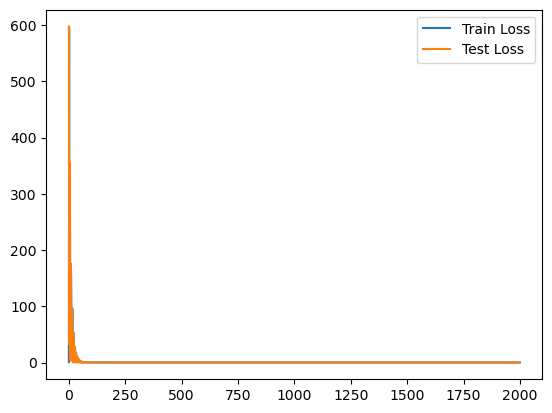

In [109]:
ax = plt.subplot()
ax.plot(train_loss, label='Train Loss')
ax.plot(test_loss, label='Test Loss')
ax.legend()

Single-step prediction

In [110]:
actual = pd.DataFrame(ss.inverse(y_test.detach().numpy().reshape(-1,1))).rename({0:'actual'},axis=1)
pred = pd.DataFrame(ss.inverse(model(X_test).detach().numpy())).rename({0:'single_pred'},axis=1)

<Axes: >

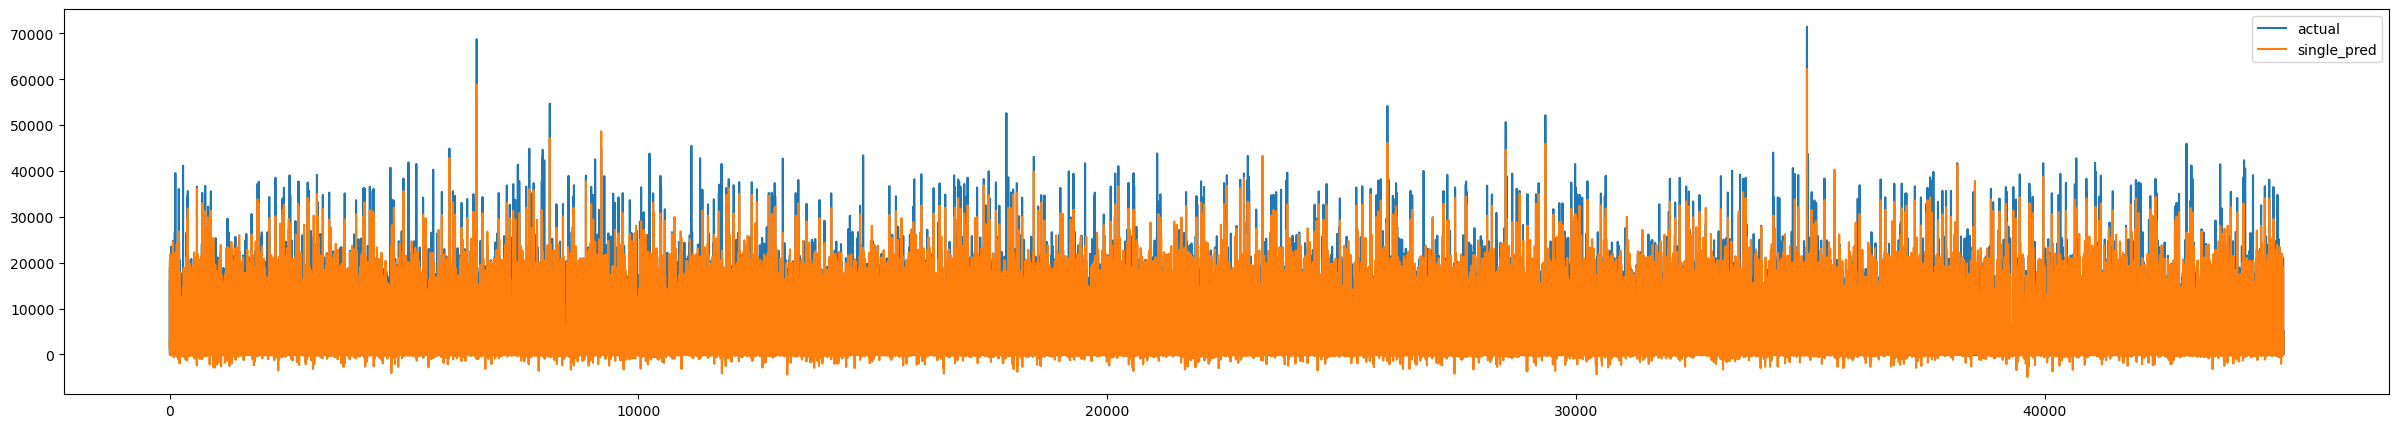

In [112]:
actual_pred = pd.concat([actual, pred], axis=1)
actual_pred.plot(figsize=(30,5))

In [113]:
rmse = float(np.sqrt(sum((actual.values - pred.values)**2)/len(actual)))
r2 = r2_score(actual, pred)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 3114.21240234375
R2: 0.7878362457785023


Recursive-step prediction

In [114]:
def recursive_step(i, pred_step, plot=True, ret='total', denorm=True):
    multi_pred = []
    currX = X_test[i]
    
    while len(multi_pred) != pred_step:
        tensor_pred = model(currX)
        currX = torch.cat([currX, tensor_pred])
        currX = currX[-time_step:]
        pred = ss.inverse(tensor_pred.detach().numpy().reshape(-1,1))
        multi_pred.append(float(pred))
    
    actual = y_test[i:i+pred_step].detach().numpy()
    multi_pred = np.array(multi_pred).reshape(-1,1)
    if denorm:
        actual = ss.inverse(actual)
    else:
        multi_pred = ss.transform(multi_pred)
    df = pd.DataFrame(np.concatenate([actual,multi_pred], axis=1)).rename({0:'actual',1:'single_rec'}, axis=1)
    total = df.sum().reset_index().T
    total.columns = total.loc['index']
    total.drop('index', inplace=True)
    total.rename({0:i}, inplace=True)
    if plot:
        df.plot()
    if ret == 'total':
        return total
    elif ret == 'frame':
        return df

In [115]:
i = 0
data = pd.DataFrame()
while True:
    try: 
        df = recursive_step(i, 168, False)
        print(i)
        data = pd.concat([data, df])
        i += 1
        clear_output(wait=True)
    except:
        print('STOP')
        break

STOP


In [342]:
data

index,actual,single_rec
0,2313056.347168,1686210.259521
1,2291462.452637,1685345.952393
2,2270768.495605,1664175.276855
3,2250864.067871,1623916.310547
4,2231572.688965,1584397.061279
...,...,...
4256,1947991.518799,1368215.838379
4257,1964521.10083,1362768.180908
4258,1980900.532471,1348776.389404
4259,1996453.279541,1337595.69165


In [344]:
r2_score(data['actual'], data['single_rec'])

0.44262929115054683

<Axes: >

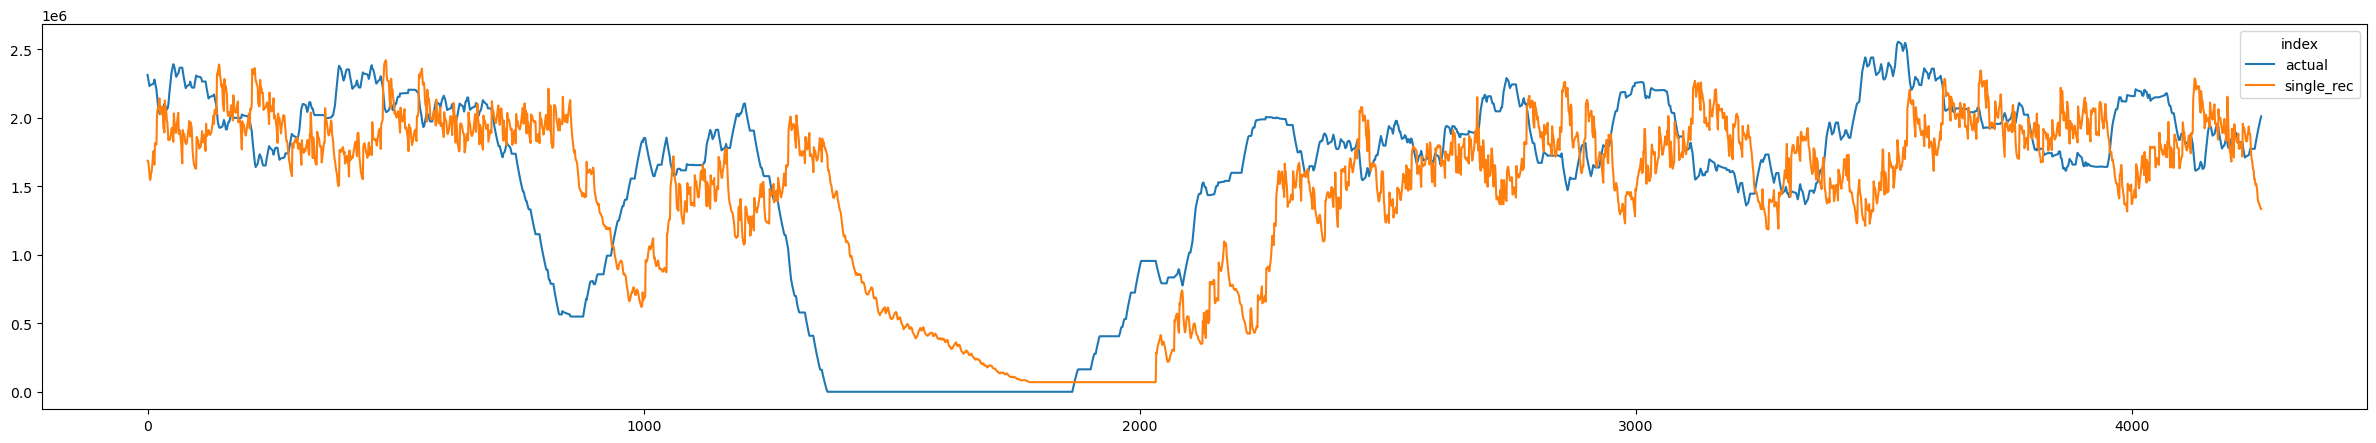

In [345]:
data.plot(figsize=(30,5))

For multiple output models

In [360]:
def multi_step(i, plot=True, ret='total', denorm=True):
    if denorm:
        actual = ss.inverse(y_test[i].detach().numpy().reshape(-1,1))
        pred = ss.inverse(model(X_test[i]).detach().numpy().reshape(-1,1))
    else:
        actual = y_test[i].detach().numpy().reshape(-1,1)
        pred = model(X_test[i]).detach().numpy().reshape(-1,1)
    df = pd.DataFrame(np.concatenate([actual, pred], axis=1)).rename({0:'actual', 1:'pred'}, axis=1)
    total = df.sum().reset_index().T
    total.columns = total.loc['index']
    total.drop('index', inplace=True)
    total.rename({0:i}, inplace=True)
    if plot:
        df.plot()
    if ret == 'total':
        return total
    elif ret == 'frame':
        return df

,actual,pred
0,20048.859375,23069.996094
1,19627.925781,23755.210938
2,19001.720703,23070.166016
3,17710.324219,21532.751953
4,17685.654297,15044.601562
...,...,...
163,20026.845703,12858.486328
164,19371.613281,13378.341797
165,18941.787109,13365.822266
166,18525.710938,14568.878906


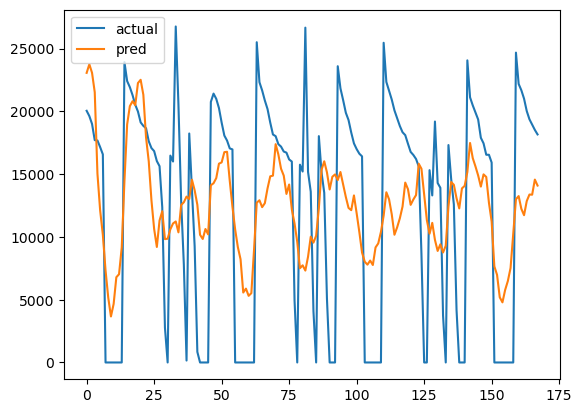

In [361]:
multi_step(700, ret='frame', denorm=True)

In [362]:
i = 0
data = pd.DataFrame()
while True:
    try: 
        df = multi_step(i, False)
        print(i)
        data = pd.concat([data, df])
        i += 1
        clear_output(wait=True)
    except:
        print('STOP')
        break

STOP


In [363]:
data

index,actual,pred
0,2108924.25,1352314.875
1,2092527.875,1358618.75
2,2101460.75,1334262.5
3,2107644.0,1348000.75
4,2112595.5,1377306.75
...,...,...
4373,1947991.5,1399261.625
4374,1964521.25,1392813.125
4375,1980900.625,1378079.0
4376,1996453.25,1363353.75


In [364]:
r2_score(data['actual'], data['pred'])

0.43902459448527786

<Axes: >

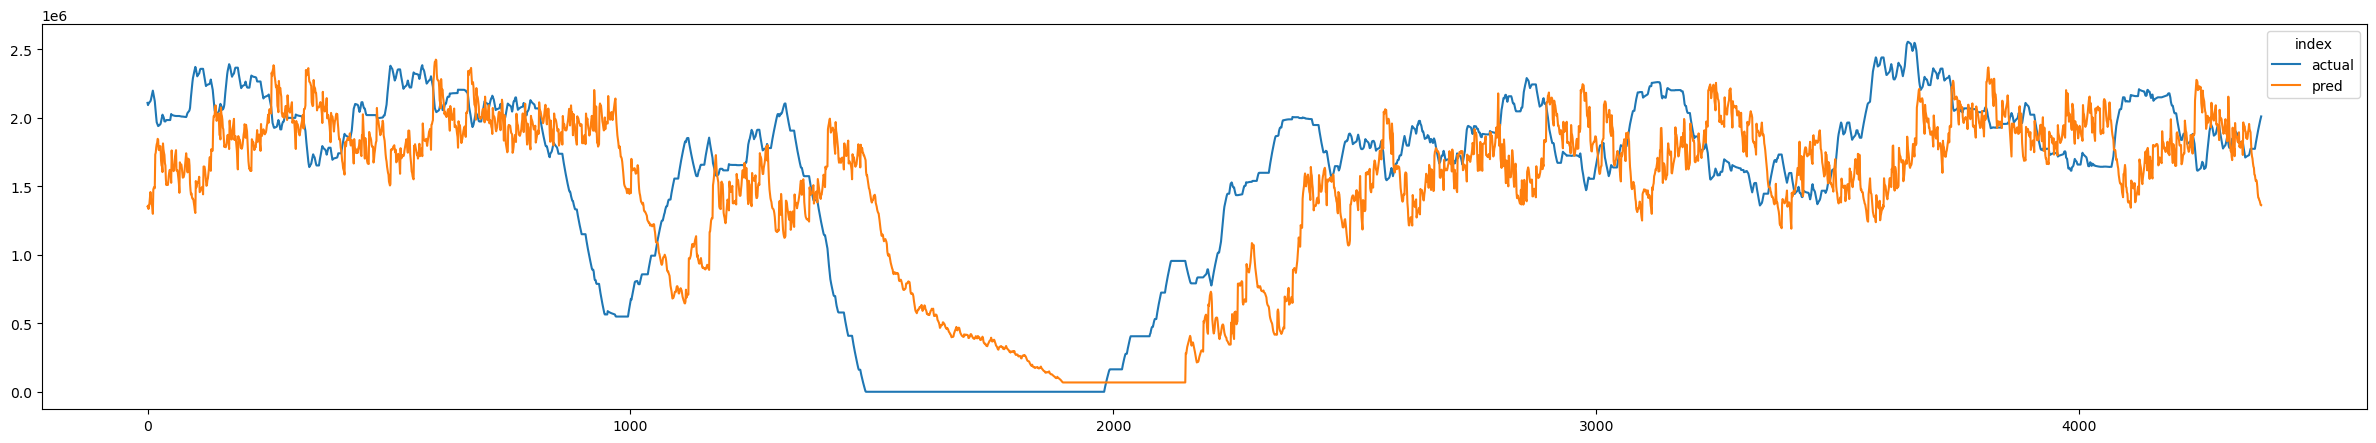

In [365]:
data.plot(figsize=(30,5))

# Save/Load Model

In [195]:
directory = input('Directory to save the model: ')
filename = input('Model Name: ')
torch.save(auto_reg, directory + filename + '.pt')

Directory to save the model: models/
Model Name: AR-IN408-SO


In [196]:
directory = input('Directory to load the model: ')
filename = input('Model Name: ')
load_mod = torch.load(directory + filename + '.pt')
model = load_mod
model.eval()

Directory to load the model: models/
Model Name: AR-IN408-SO


Linear(in_features=408, out_features=1, bias=True)